# Trabalho de análise de dados da matéria do professor Laio
-----
Aluno: Leonardo José
Tema: Análise de fuga de corrente devido a deposicao de sal em insuladores em alto mar
O presente trabalho utiliza a combinacao de arquiteturas Seq2Seq e LSTM fornecidas pelo professor, com a adicao de estrutura "atention" para auxiliar a rede a focar em elementos relevante sna hora do treinamento. O uso de rede Seq2Seq + LSTM se deve ao fato dos dados terem relacao temporal entre eles, com um input "rolante" de uma sequencia e um output de uma sequencia de dados que serao a previsao da corrente nos insuladores.

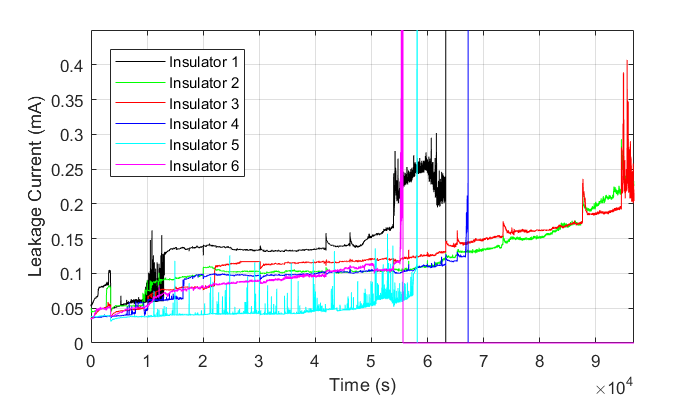

#### Obtencao dos dados:

             Insulador 1  Insulador 2  Insulador 3  Insulador 4  Insulador 5  \
Insulador 1     1.000000    -0.531576    -0.440451     0.796962     0.664670   
Insulador 2    -0.531576     1.000000     0.947203    -0.559488    -0.627594   
Insulador 3    -0.440451     0.947203     1.000000    -0.446580    -0.587499   
Insulador 4     0.796962    -0.559488    -0.446580     1.000000     0.607351   
Insulador 5     0.664670    -0.627594    -0.587499     0.607351     1.000000   
Insulador 6     0.471816    -0.427254    -0.388799     0.488188     0.585946   

             Insulador 6  
Insulador 1     0.471816  
Insulador 2    -0.427254  
Insulador 3    -0.388799  
Insulador 4     0.488188  
Insulador 5     0.585946  
Insulador 6     1.000000  
interval columns not set, guessing: ['Insulador 1', 'Insulador 2', 'Insulador 3', 'Insulador 4', 'Insulador 5', 'Insulador 6']


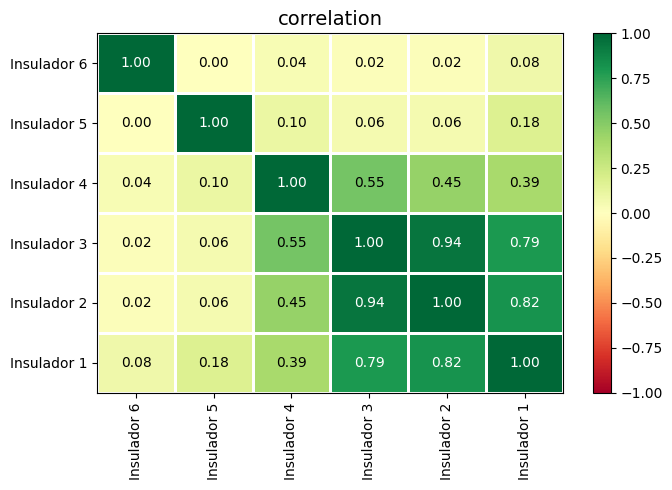

In [1]:
import pandas as pd

# Bibliotecas para ver a correlacao do tipo Phi-K (Nao só linear)
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# Pegar os dados dos insuladores do arquivo excel com pandas
file_path = 'BaseDados.xlsx'
col_insulators = [9, 10, 11, 12, 13, 14]
insulators_df = pd.read_excel(file_path, usecols=col_insulators)
new_column_names = [f'Insulador {i+1}' for i in range(len(col_insulators))]
insulators_df.columns = new_column_names

# Calcular a matriz de correlação de Pearson
correlation_df = insulators_df.corr(method='pearson')
print(correlation_df)

# Calcular a matriz de correlação Phik
phik_corr_matrix = insulators_df.phik_matrix()
plot_correlation_matrix(phik_corr_matrix.values, x_labels=phik_corr_matrix.columns, y_labels=phik_corr_matrix.index)



### Dados obtidos com a correlacao
1. Verificou-se que existe uma forte correlacao entre o insulador 2 e 3 tanto com Pearson, quanto Phi-K.
2. Verificou-se uma forte correlacao entre o insulador 4 e 1, utilzando Pearson.
3. Verificou-se uma forte correlacao entre o insulador 2 e 3 com 1, utilizando Phi-K

### Convertendo os arrays de dados dos insuladores de dataframes para tensores
Nessa etapa os dados sao convertidos para tensor, sao removidos os zeros no final dos arrays para nao treinar a rede com dados que nao existem e é divido cada insulador na metade, uma parte para teste e uma parte para treinamento.

In [14]:
import torch

train_tensors = []
test_tensors = []

for num_insulator in range(len(col_insulators)):
    insulator_column = insulators_df.iloc[:, num_insulator]
    insulator_numpy = insulator_column.to_numpy()
    insulator_tensor = torch.tensor(insulator_numpy, dtype=torch.float32)
    
    # Tirar os zeros no final do array de dados
    non_zero_indices = torch.nonzero(insulator_tensor).squeeze(-1)
    last_non_zero_idx = non_zero_indices[-1].item()
    insulator_tensor = insulator_tensor[:last_non_zero_idx + 1]
    
    # Dividir o tensor em treino e teste (metade para cada)
    split_index = len(insulator_tensor) // 2
    train_tensor = insulator_tensor[:split_index]
    test_tensor = insulator_tensor[split_index:] 
    train_tensors.append(train_tensor)
    test_tensors.append(test_tensor)
    
    print("Tensor referente ao insulador: ", num_insulator + 1)
    print("Tamanho tensor de treinamento: ", train_tensor.shape[0], " leituras.")
    print("Treinamento:", train_tensor)
    print("Teste:", test_tensor, "\n")

# Agora, train_tensors e test_tensors possuem as metades correspondentes de cada tensor


Tensor referente ao insulador:  1
Tamanho tensor de treinamento:  31623  leituras.
Treinamento: tensor([0.0540, 0.0550, 0.0540,  ..., 0.1320, 0.1320, 0.1320])
Teste: tensor([0.1310, 0.1320, 0.1310,  ..., 0.2150, 0.2030, 1.0000]) 

Tensor referente ao insulador:  2
Tamanho tensor de treinamento:  48408  leituras.
Treinamento: tensor([0.0490, 0.0500, 0.0500,  ..., 0.1020, 0.1020, 0.1020])
Teste: tensor([0.1020, 0.1020, 0.1020,  ..., 0.2270, 0.2270, 0.2260]) 

Tensor referente ao insulador:  3
Tamanho tensor de treinamento:  48408  leituras.
Treinamento: tensor([0.0350, 0.0360, 0.0350,  ..., 0.1180, 0.1180, 0.1180])
Teste: tensor([0.1180, 0.1180, 0.1180,  ..., 0.2090, 0.2040, 0.2060]) 

Tensor referente ao insulador:  4
Tamanho tensor de treinamento:  33624  leituras.
Treinamento: tensor([0.0350, 0.0350, 0.0350,  ..., 0.0980, 0.0980, 0.0980])
Teste: tensor([0.0970, 0.0980, 0.0980,  ..., 0.2470, 0.2310, 1.0000]) 

Tensor referente ao insulador:  5
Tamanho tensor de treinamento:  29088  lei

### Tentando simplificar os sinais temporais em sub-sinais temporais
Tentativa com Wavelet, nao ficou tao bom quanto Wavelet Empírica

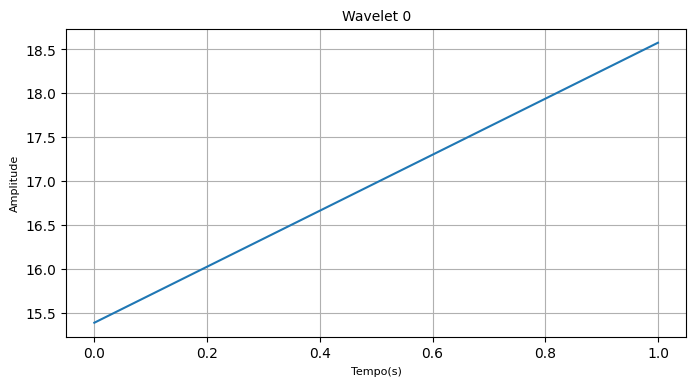

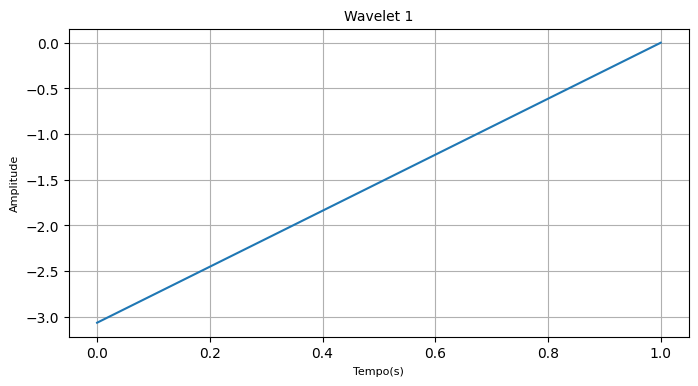

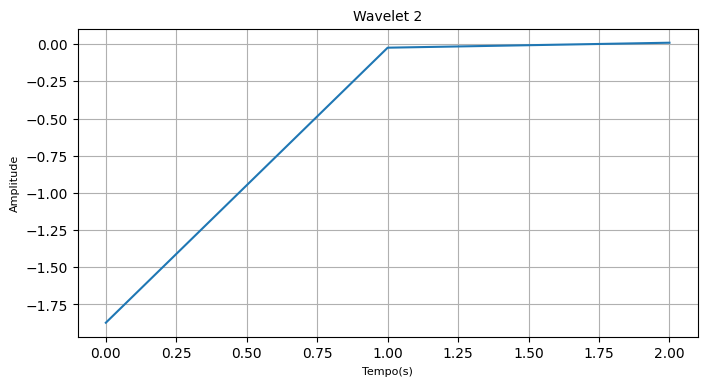

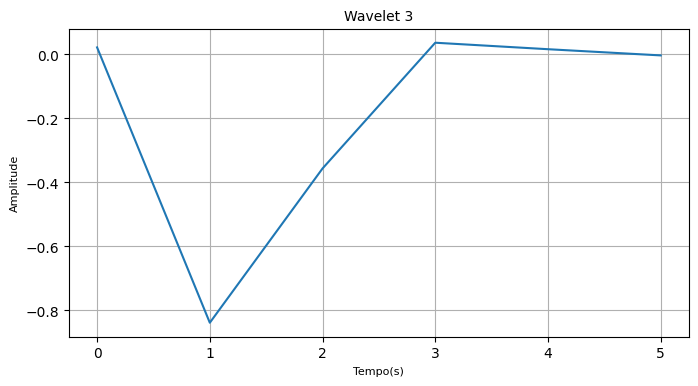

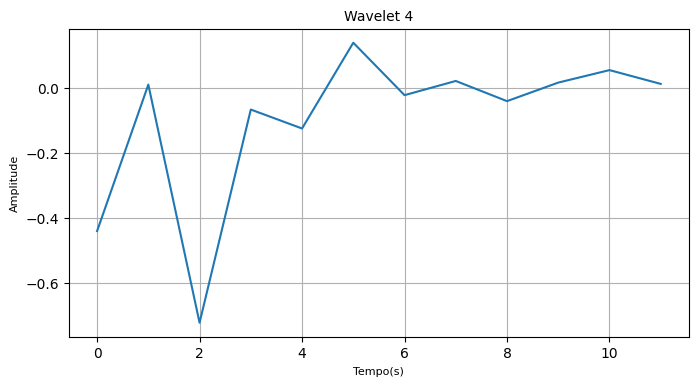

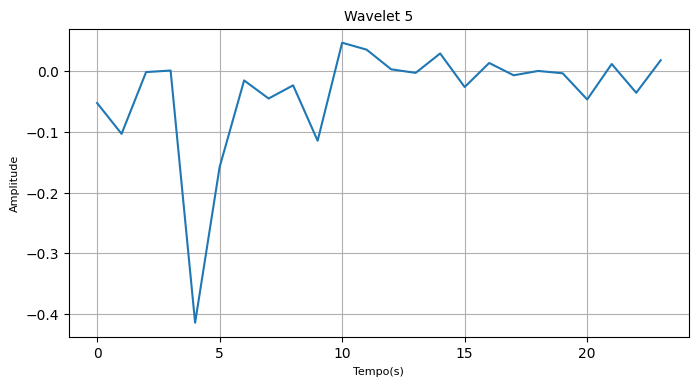

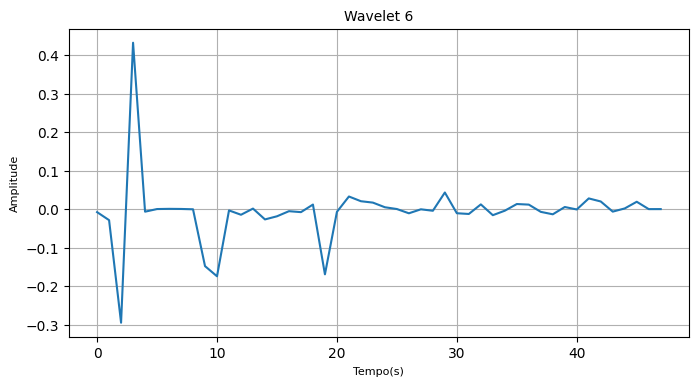

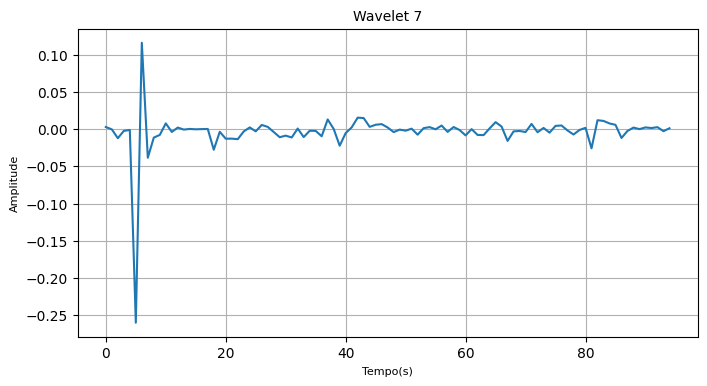

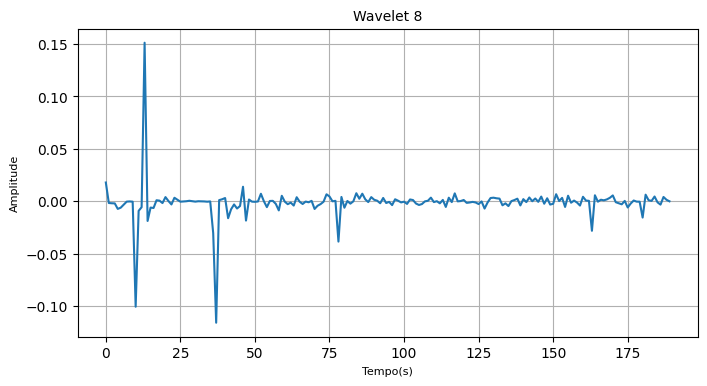

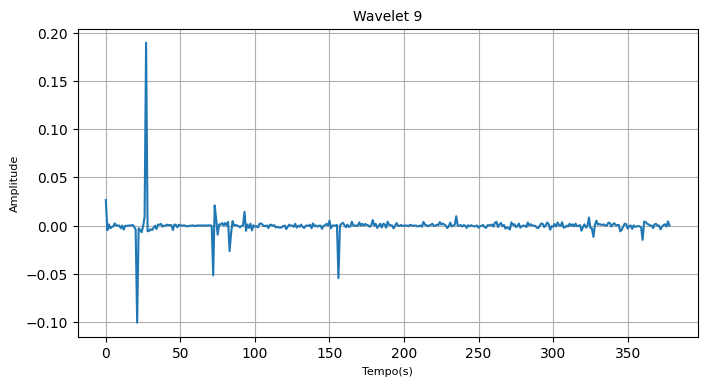

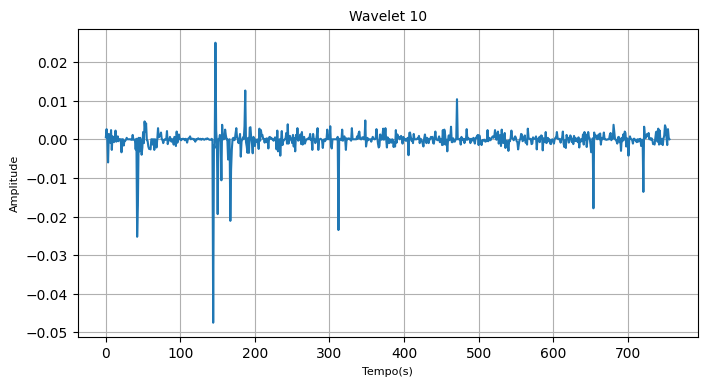

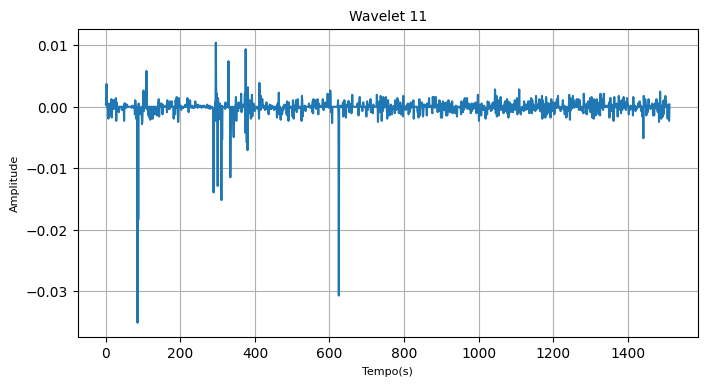

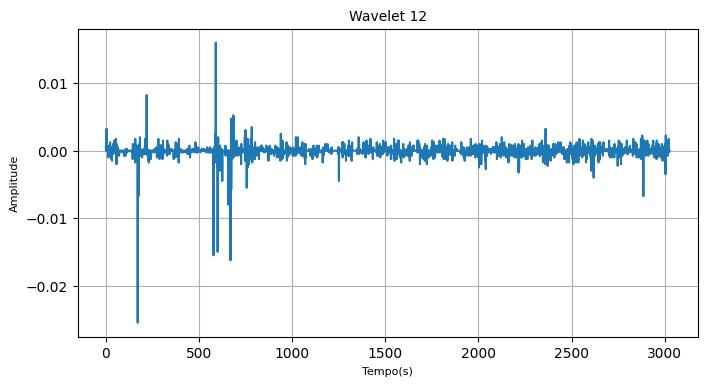

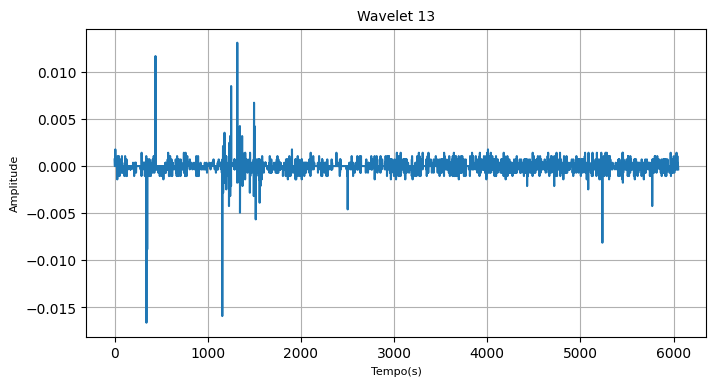

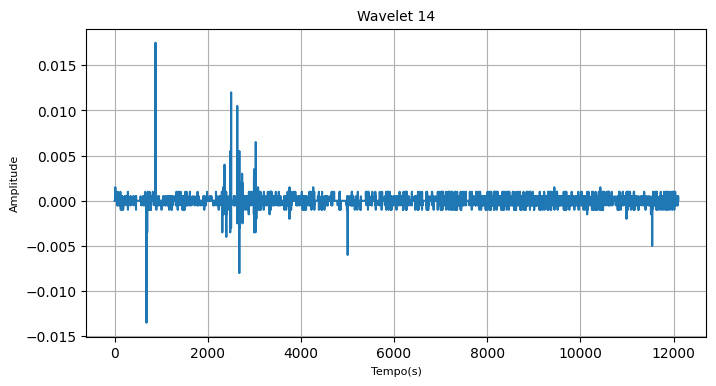

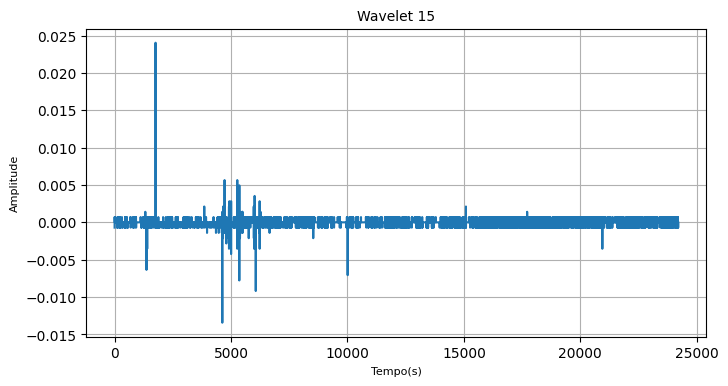

In [25]:
import pywt
import matplotlib.pyplot as plt

insulator_data = train_tensors[1] # Mudar o insulador que será 

# Aplicar a decomposicao em wavelet discreta (DWT) com a primeira wavelet de Daubechies (db1)
coeffs = pywt.wavedec(insulator_data, 'db1')

for i, coeff in enumerate(coeffs):
    plt.figure(figsize=(8, 4))
    plt.plot(coeff)
    plt.title(f'Wavelet {i}', fontsize=10) 
    plt.xlabel('Tempo(s)', fontsize=8)  
    plt.ylabel('Amplitude', fontsize=8) 
    plt.grid()  
    plt.show() 

Tentativa com Wavelet Empírica, apresenta um melhor resultado para análise e pode-se escolher a quantidade de sub-sinais.

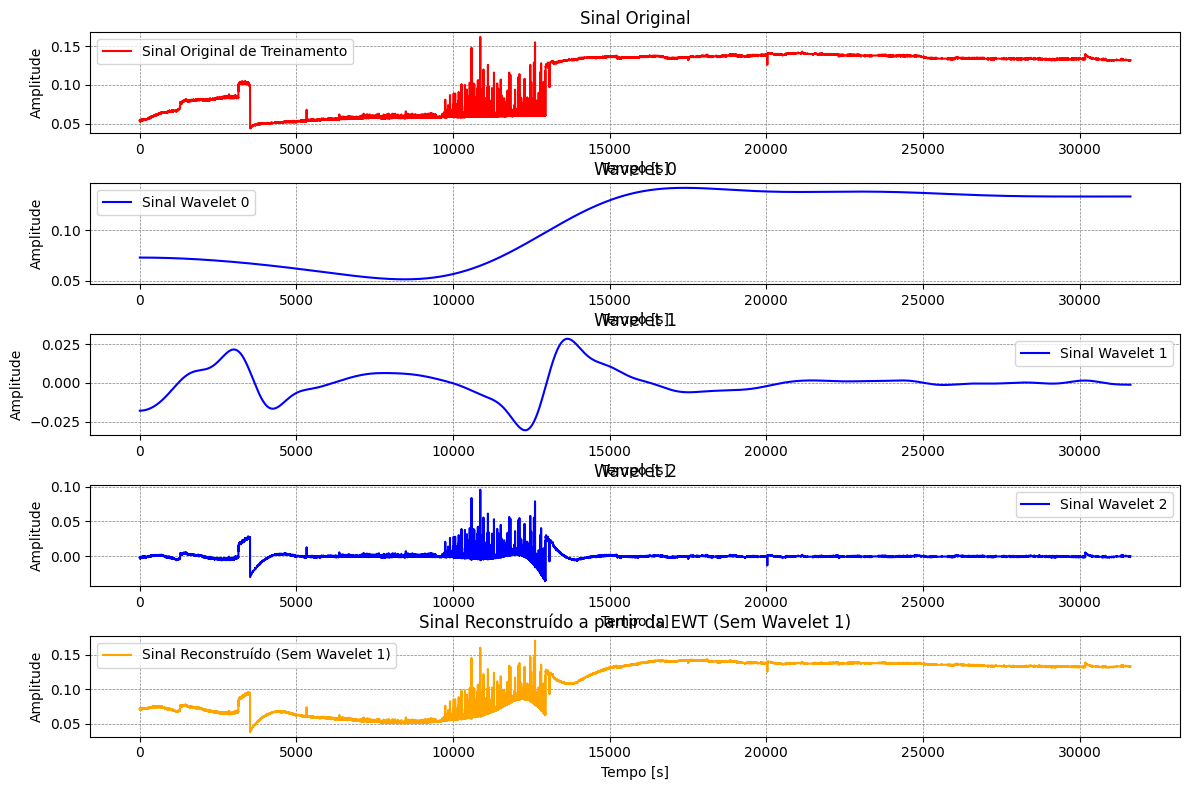

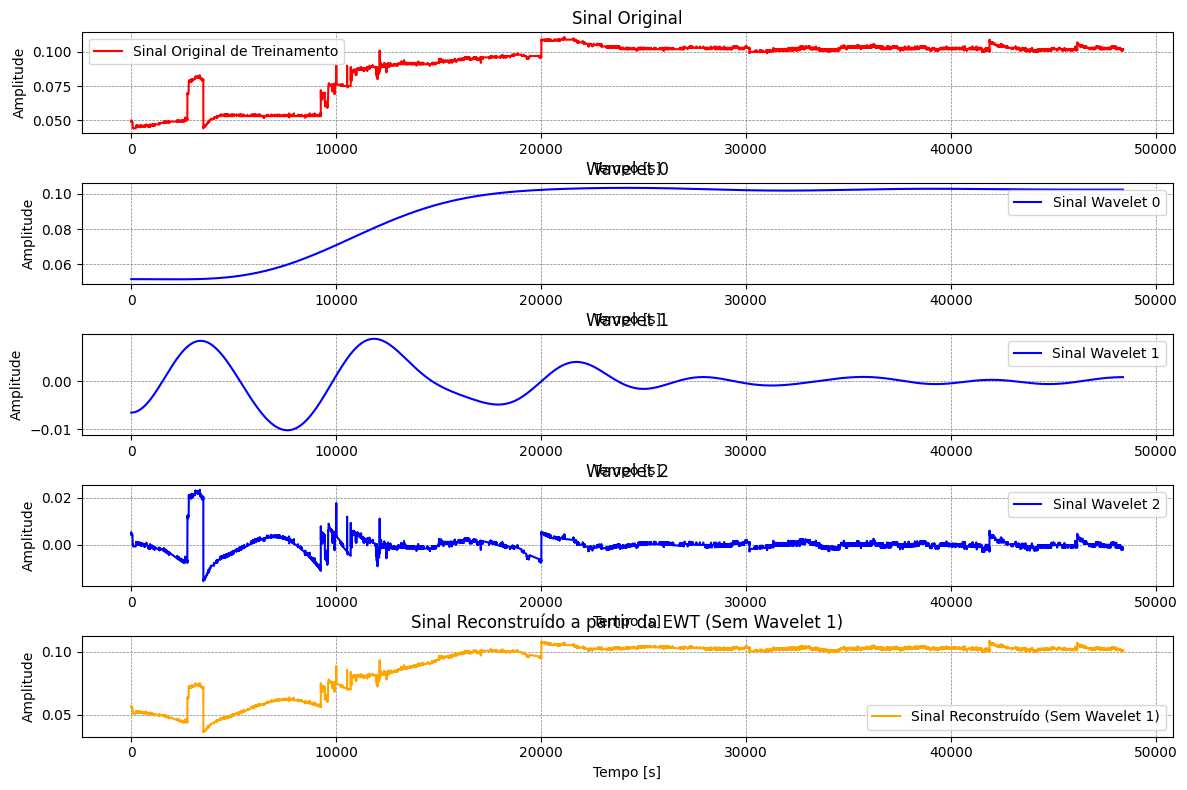

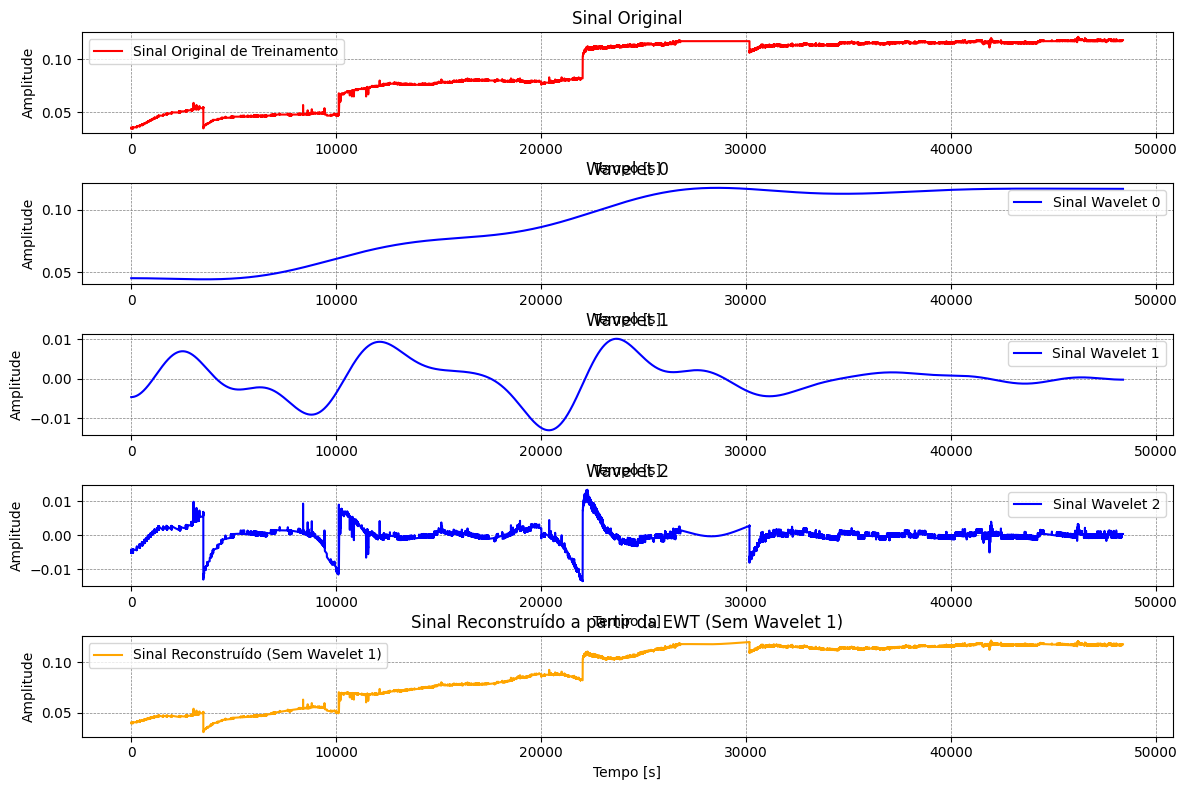

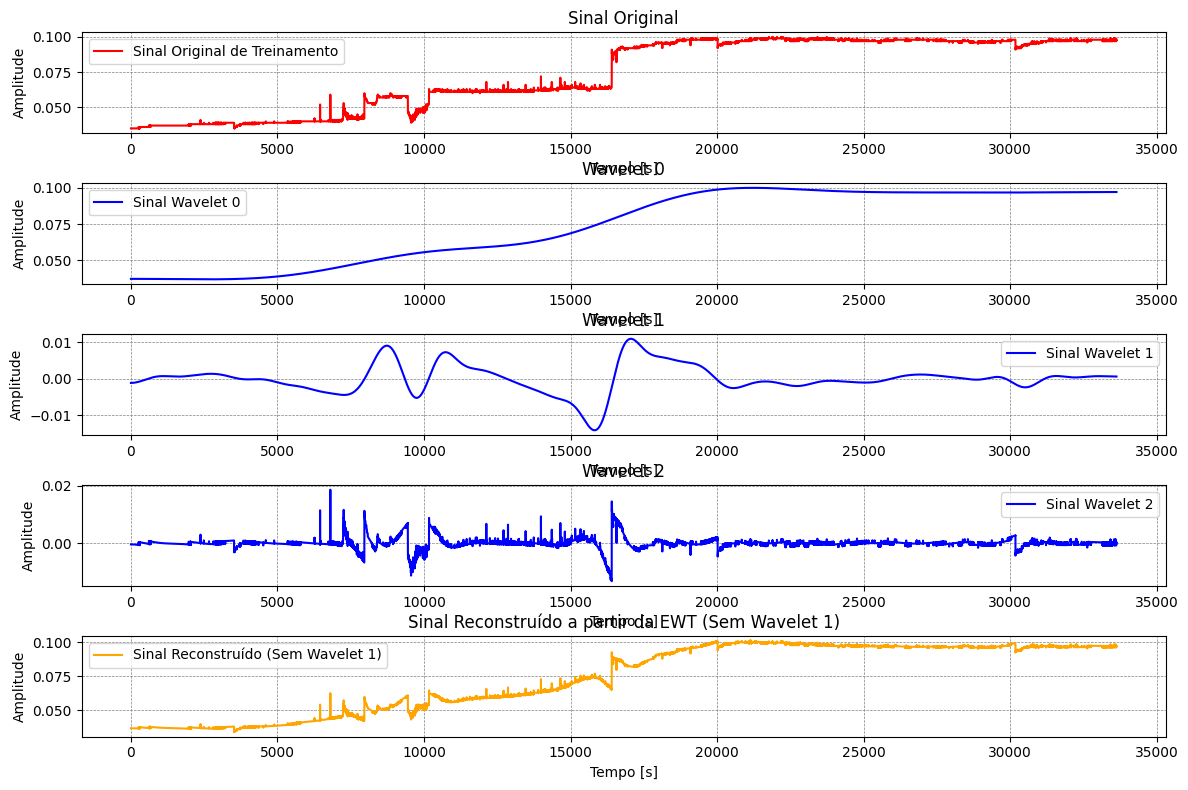

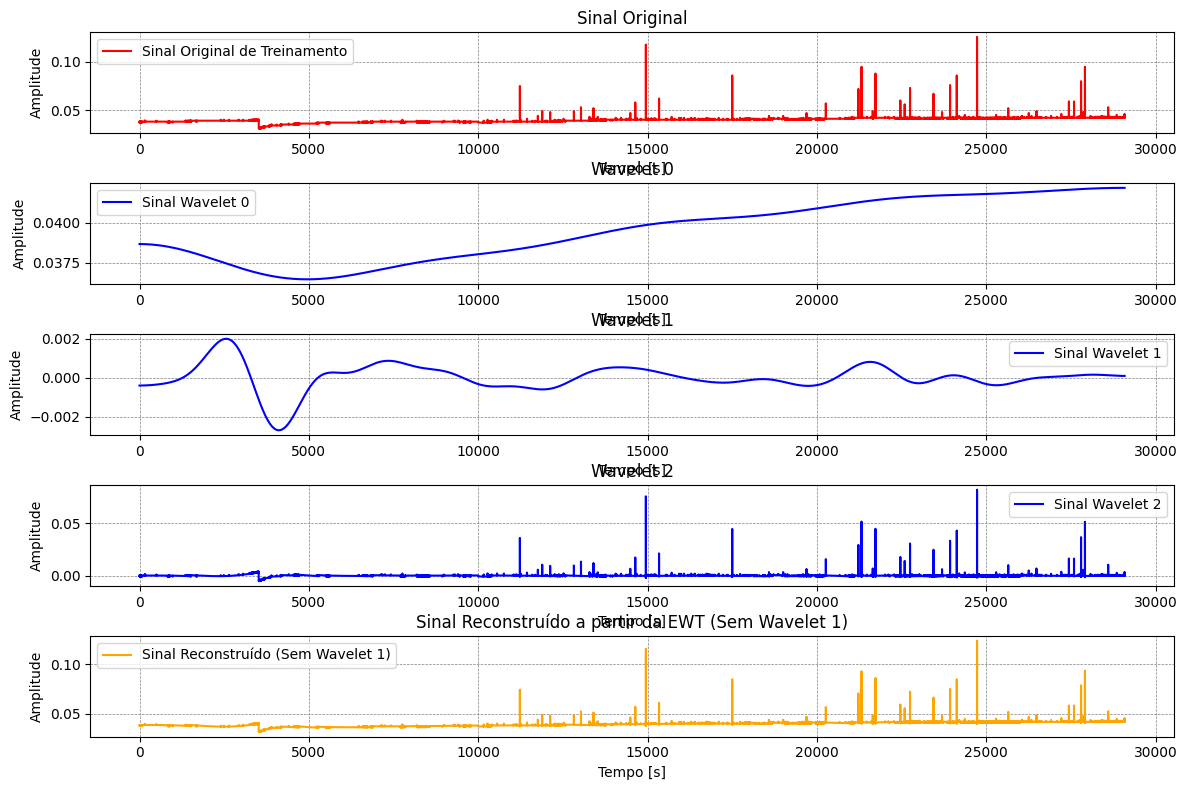

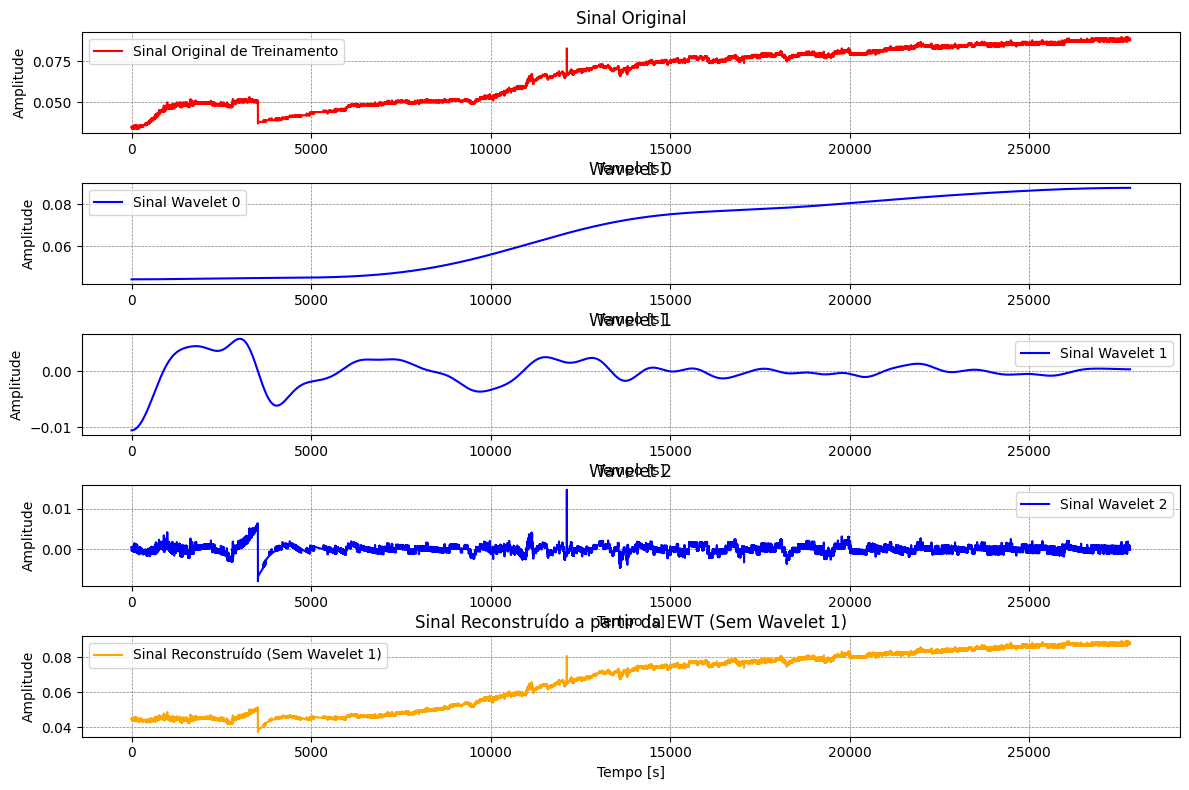

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import ewtpy

for train_tensor in train_tensors:
    # Número de wavelets
    num_wavelets = 3
    insulator_data = train_tensor
    t = np.arange(0, len(insulator_data)) 
    insulator_data_numpy = insulator_data.numpy()

    # Aplicar a Wavelet Empírica
    ewt, mfb, boundaries = ewtpy.EWT1D(insulator_data_numpy, N=num_wavelets)
    reconstructed_signal = np.sum(ewt, axis=1)

    plt.figure(figsize=(12, 8))

    # Plotar o sinal original
    plt.subplot(2 + num_wavelets, 1, 1)
    plt.plot(t, insulator_data_numpy, label='Sinal Original de Treinamento', color='red')
    plt.title('Sinal Original')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Amplitude')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.legend()

    # Plotar o sinal de cada wavelet
    for wavelet in range(num_wavelets):
        plt.subplot(2 + num_wavelets, 1, wavelet + 2)
        plt.plot(t, ewt[:, wavelet], label=f'Sinal Wavelet {wavelet}', color='blue')
        plt.title(f'Wavelet {wavelet}')
        plt.xlabel('Tempo [s]')
        plt.ylabel('Amplitude')
        plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
        plt.legend()

    # Remover a segunda wavelet (wavelet 1) e reconstruir o sinal
    ewt_last_wavelets = np.delete(ewt, [1], axis=1)
    reconstructed_without_wavelet1 = np.sum(ewt_last_wavelets, axis=1)

    # Plotar o sinal reconstruído sem a segunda wavelet
    plt.subplot(2 + num_wavelets, 1, num_wavelets + 2)
    plt.plot(t, reconstructed_without_wavelet1, label='Sinal Reconstruído (Sem Wavelet 1)', color='orange')
    plt.title('Sinal Reconstruído a partir da EWT (Sem Wavelet 1)')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Amplitude')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.legend()

    # Ajustar o layout e aumentar o espaço entre os subplots
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)  # Ajusta o espaço entre os subplots
    plt.show()




### Rede neural do professor Seq2Seq + LSTM

In [5]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Verifique se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Definindo a classe Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, input_seq):
        output, (hidden, cell) = self.lstm(input_seq)
        return hidden, cell

# Definindo a classe Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(output_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden, cell):
        output, (hidden, cell) = self.lstm(input_seq, (hidden, cell))
        prediction = self.fc_out(output)
        return prediction, hidden, cell

# Definindo a classe Seq2Seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_seq, target_seq_len, teacher_forcing_ratio=0.5):
        batch_size = source_seq.shape[1]
        output_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(target_seq_len, batch_size, output_size).to(source_seq.device)

        hidden, cell = self.encoder(source_seq)

        decoder_input = torch.zeros(1, batch_size, output_size).to(source_seq.device)

        for t in range(target_seq_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[t] = output
            use_teacher_forcing = np.random.random() < teacher_forcing_ratio
            decoder_input = output if not use_teacher_forcing else source_seq[t].unsqueeze(0)

        return outputs

# Preparar os dados do insulador
def generate_insulator_data(insulator_tensor, seq_len=50):
    data = []
    for i in range(len(insulator_tensor) - seq_len):
        data.append(insulator_tensor[i:i + seq_len])
    data = np.array(data)
    data = data.reshape((data.shape[0], seq_len, 1))  # Adiciona a dimensão para a LSTM

    train_size = int(0.8 * data.shape[0])
    X_train = data[:train_size]
    X_test = data[train_size:]

    return torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)

# Treinamento do modelo Seq2Seq
def train_seq2seq(model, X_train, epochs=50, learning_rate=0.01, batch_size=64, teacher_forcing_ratio=0.5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_batches = X_train.shape[0] // batch_size

    for epoch in range(epochs):
        model.train()  # Definir o modelo como em treinamento
        epoch_loss = 0

        for i in range(num_batches):
            batch_start = i * batch_size
            batch_end = batch_start + batch_size
            batch_data = X_train[batch_start:batch_end]
            
            optimizer.zero_grad()
            
            outputs = model(batch_data.permute(1, 0, 2), batch_data.shape[1], teacher_forcing_ratio)
            loss = criterion(outputs, batch_data.permute(1, 0, 2))
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / num_batches
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {avg_loss:.4f}')

# Avaliação e plotagem
def evaluate_seq2seq(model, X_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.permute(1, 0, 2), X_test.shape[1], teacher_forcing_ratio=0.0)
        predictions = predictions.permute(1, 0, 2).cpu().numpy()  # Converter para numpy para plotagem
        X_test = X_test.cpu().numpy()  # Converter para numpy para plotagem

        # Plotar as sequências reais e previstas
        plt.figure(figsize=(10, 6))
        plt.plot(X_test[0], label="Actual Sequence", color='green')
        plt.plot(predictions[0], label="Predicted Sequence", linestyle=":", color='red')
        plt.title("Actual vs Predicted Insulator Sequence")
        plt.xlabel("Time step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

# Colocando tudo junto
if __name__ == "__main__":
    # Converter para tensor
    insulator_tensor = insulators_tensors[1]

    # Gerar os dados para treinamento e teste
    X_train, X_test = generate_insulator_data(insulator_tensor, seq_len=50)

    # Inicializar o modelo
    input_size = 1  # Número de recursos (1 para um sinal unidimensional)
    hidden_size = 32  # Ajustado para menor uso de memória
    output_size = 1  # Para previsão de um único valor

    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(hidden_size, output_size).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder).to(device)

    # Treinar o modelo
    train_seq2seq(seq2seq_model, X_train, epochs=25, learning_rate=0.01, batch_size=64, teacher_forcing_ratio=0.5)

    # Avaliar e plotar
    evaluate_seq2seq(seq2seq_model, X_test)


Using device: cpu


KeyboardInterrupt: 

Using device: cpu
Epoch [10/200], Loss: 0.4678
Epoch [20/200], Loss: 0.3740
Epoch [30/200], Loss: 0.2363
Epoch [40/200], Loss: 0.1929
Epoch [50/200], Loss: 0.0654
Epoch [60/200], Loss: 0.0450
Epoch [70/200], Loss: 0.0295
Epoch [80/200], Loss: 0.0158
Epoch [90/200], Loss: 0.0111
Epoch [100/200], Loss: 0.0035
Epoch [110/200], Loss: 0.0041
Epoch [120/200], Loss: 0.0027
Epoch [130/200], Loss: 0.0026
Epoch [140/200], Loss: 0.0017
Epoch [150/200], Loss: 0.0022
Epoch [160/200], Loss: 0.0012
Epoch [170/200], Loss: 0.0009
Epoch [180/200], Loss: 0.0012
Epoch [190/200], Loss: 0.0009
Epoch [200/200], Loss: 0.0007


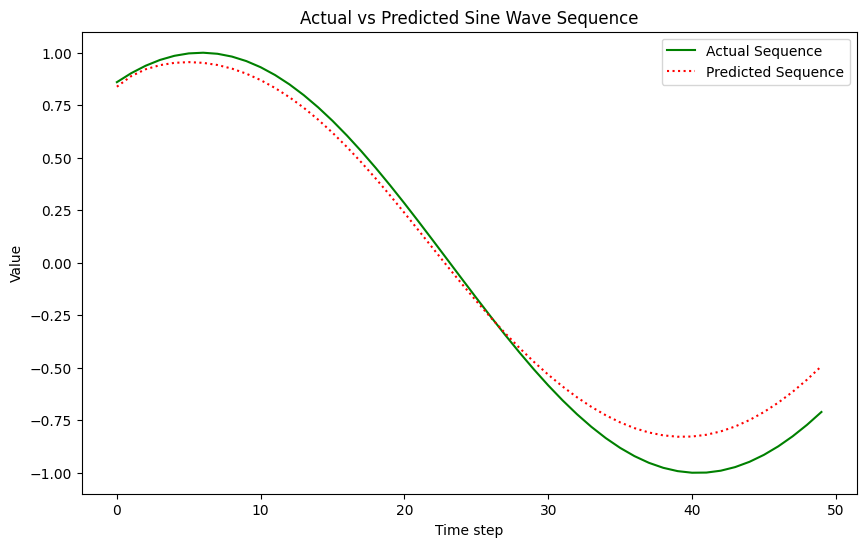

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, input_seq):
        output, (hidden, cell) = self.lstm(input_seq)
        return hidden, cell

# Step 2: Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(output_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden, cell):
        output, (hidden, cell) = self.lstm(input_seq, (hidden, cell))
        prediction = self.fc_out(output)
        return prediction, hidden, cell

# Step 3: Define the Seq2Seq model class with Teacher Forcing
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_seq, target_seq_len, teacher_forcing_ratio=0.5):
        batch_size = source_seq.shape[1]
        output_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(target_seq_len, batch_size, output_size).to(source_seq.device)

        hidden, cell = self.encoder(source_seq)

        decoder_input = torch.zeros(1, batch_size, output_size).to(source_seq.device)

        for t in range(target_seq_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[t] = output
            use_teacher_forcing = np.random.random() < teacher_forcing_ratio
            decoder_input = output if not use_teacher_forcing else source_seq[t].unsqueeze(0)

        return outputs

# Step 4: Generate Sine Wave Data
def generate_sine_data(seq_len=50, n_samples=1000):
    X = np.linspace(0, 100, n_samples)
    y = np.sin(X)
    
    data = []
    for i in range(len(y) - seq_len):
        data.append(y[i:i+seq_len])

    data = np.array(data)
    data = data.reshape((data.shape[0], seq_len, 1))

    train_size = int(0.8 * data.shape[0])
    X_train = data[:train_size]
    X_test = data[train_size:]

    return torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)

# Step 5: Training the Seq2Seq model
def train_seq2seq(model, X_train, epochs=100, learning_rate=0.001, teacher_forcing_ratio=0.5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()

        outputs = model(X_train.permute(1, 0, 2), X_train.shape[1], teacher_forcing_ratio)
        
        loss = criterion(outputs, X_train.permute(1, 0, 2))
        
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Step 6: Evaluation with plotting
def evaluate_seq2seq(model, X_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.permute(1, 0, 2), X_test.shape[1], teacher_forcing_ratio=0.0)
        predictions = predictions.permute(1, 0, 2).cpu().numpy()  # Convert to numpy for plotting
        X_test = X_test.cpu().numpy()  # Convert to numpy for plotting

        # Plot the actual and predicted sequences
        plt.figure(figsize=(10, 6))
        plt.plot(X_test[0], label="Actual Sequence", color='green')
        plt.plot(predictions[0], label="Predicted Sequence", linestyle=":", color='red')
        plt.title("Actual vs Predicted Sine Wave Sequence")
        plt.xlabel("Time step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

# Step 7: Putting it all together
if __name__ == "__main__":
    # Generate sine wave data
    X_train, X_test = generate_sine_data(seq_len=50, n_samples=1100)

    # Define the model parameters
    input_size = 1
    hidden_size = 64
    output_size = 1

    # Initialize Encoder, Decoder, and Seq2Seq model
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(hidden_size, output_size).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder).to(device)

    # Train the model
    train_seq2seq(seq2seq_model, X_train, epochs=200, learning_rate=0.001, teacher_forcing_ratio=0.5)

    # Evaluate and plot
    evaluate_seq2seq(seq2seq_model, X_test)